In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np

In [1]:
import sys
#path_module = r'C:\Users\je7560\Downloads\matheus\kinematics-robotics\src\kinematicsrobotics'
path_module = r'C:\Users\mathe\OneDrive\Graduação - UFC\Engenharia da Computação\TCC\Códigos e implementações\V.2\kinematics-robotics\src\kinematicsrobotics'
sys.path.append(path_module)
import datahandler

## Base de dados

In [2]:
path_data = r'src\data\ready\dataset-radius-0.5cm.csv'
path_project = r'C:\Users\mathe\OneDrive\Graduação - UFC\Engenharia da Computação\TCC\Códigos e implementações\V.2\kinematics-robotics'
#path_project = r'C:\Users\je7560\Downloads\matheus\kinematics-robotics'
ext = datahandler.extract(path_project)

dataset = ext.dataframe(path_data)


### Atributos e saídas

#### Análise dos dados

In [3]:
print(dataset.columns)

Index(['theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'p_x', 'p_y',
       'p_z', 'roll', 'pich', 'yaw'],
      dtype='object')


In [4]:
from numpy import array
def partition(dataset,axis):
    return array(dataset.iloc[:,axis[0]:axis[1]])


y = partition(dataset,[0,4])
x = partition(dataset,[5,11])

In [5]:
print(f"Tamanho do dataset: {y.shape}")

Tamanho do dataset: (15324, 4)


In [6]:
y[0:3]

array([[ 0,  0,  0,  0],
       [ 0,  0, 12,  0],
       [ 0,  0, 12, 12]], dtype=int64)

In [7]:
x[0:3]

array([[ 5.40000000e+01, -1.10218212e-15,  1.00000000e+01,
         2.35619449e+00, -1.57079633e+00,  7.85398163e-01],
       [ 5.32133136e+01, -2.47712141e-15,  2.51517913e+00,
         3.14159265e+00, -1.36135682e+00,  2.75203954e-16],
       [ 5.36066568e+01, -2.24796486e-15,  6.25758957e+00,
         2.33481267e+00, -1.57079633e+00,  8.06779988e-01]])

## Pré-processamento de dados

In [17]:
# Proporção 
size_train = 0.7
size_val = 0.2
size_test = 0.1

# Proporção relativa
size_val = (1 - size_train/(size_train+size_val))
size_train = size_train/(size_train+size_val)


In [8]:
from sklearn.model_selection import train_test_split
def split(x, y, test_size):
    return train_test_split(x, y, test_size=test_size)

### Divisão treino e teste

In [39]:
x_train, x_test, y_train, y_test = split(x,y,0.1)

#### informações

In [10]:
print(f"{len(x_train)}")
print(f"{len(x_test)}")

13791
1533


### Normalização dos dados

In [40]:
from sklearn.preprocessing import StandardScaler
from numpy import mean,std

def zscore(data):
    scaler = StandardScaler()
    means = mean(data,axis=0)
    stds = std(data,axis=0)
    data = scaler.fit_transform(data)
    return data, means,stds

x_train,_,_ = zscore(x_train)
y_train,_,_ = zscore(y_train)

## Modelo

In [90]:
from sklearn.neural_network import MLPRegressor

def MLP():
    LEARNING_RATE = 0.01
    LEARNING = 'constant'
    EPOCHS = 2000 # Número máximo de épocas
    EPOCHS_NOCHANGE = 10
    ERROR = 1e-4
    MOMENTUM = 0.01
    VALIDACION = 0.1
    FUNCTION_ACTIVA = 'relu'
    VERDOSE = True
    model = MLPRegressor(activation= FUNCTION_ACTIVA,
                         learning_rate_init = LEARNING_RATE,
                         learning_rate = LEARNING,
                         max_iter = EPOCHS,
                         tol = ERROR,
                         n_iter_no_change = EPOCHS_NOCHANGE,
                         early_stopping = True,
                         verbose=VERDOSE)
    return model

In [91]:
mlp = MLP()
mlp.set_params(hidden_layer_sizes = (400,200,400))

MLPRegressor(early_stopping=True, hidden_layer_sizes=(400, 200, 400),
             learning_rate_init=0.01, max_iter=2000, verbose=True)

In [129]:
#model = MLPRegressor(hidden_layer_sizes=(100, 200), #validação
                    # activation='tanh',  # Função de ativação da camada oculta
                    # random_state=42)

## Seleção de modelos

In [19]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=3, test_size=size_val, random_state=42)

# for train_index, test_index in ss.split(x_train, y_train):
#     print("Índices de Treino:", len(train_index))
#     print("Índices de Teste:", len(test_index))
#     print("----------------------")

In [24]:
def grid_search(X_train, y_train, param_grid, model):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X_train, y_train)
    #.ravel()

    # Avaliação do melhor hiperparâmetro
    melhor_modelo = grid_search.best_estimator_
    y_pred = melhor_modelo.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    print("Melhores hiperparâmetros:", grid_search.best_params_)
    print(f"\nMSE nos dados completos: {mse}")
    print(f"R² nos dados completos: {r2}")

    # Extrair os resultados da validação cruzada
    resultados = pd.DataFrame(grid_search.cv_results_)

    colunas_interesse = ['param_hidden_layer_sizes', 'mean_test_score', 'std_test_score']
    resultados_interesse = resultados[colunas_interesse]

    print("Avaliação do MSE para cada hiperparâmetro testado:")
    print(resultados_interesse)
    return resultados

## Treinamento

In [92]:
# Treinando o modelo
mlp.fit(x_train, y_train)



Iteration 1, loss = 0.11234233
Validation score: 0.933933
Iteration 2, loss = 0.01620417
Validation score: 0.963760
Iteration 3, loss = 0.01110883
Validation score: 0.973858
Iteration 4, loss = 0.01150467
Validation score: 0.969894
Iteration 5, loss = 0.00841735
Validation score: 0.974381
Iteration 6, loss = 0.00981549
Validation score: 0.979453
Iteration 7, loss = 0.00736239
Validation score: 0.986174
Iteration 8, loss = 0.00673230
Validation score: 0.985344
Iteration 9, loss = 0.00716760
Validation score: 0.979615
Iteration 10, loss = 0.00855283
Validation score: 0.987841
Iteration 11, loss = 0.00577737
Validation score: 0.991189
Iteration 12, loss = 0.00534091
Validation score: 0.990745
Iteration 13, loss = 0.00564985
Validation score: 0.978471
Iteration 14, loss = 0.00768047
Validation score: 0.971210
Iteration 15, loss = 0.00735879
Validation score: 0.985023
Iteration 16, loss = 0.00712341
Validation score: 0.989003
Iteration 17, loss = 0.00634947
Validation score: 0.986790
Iterat

MLPRegressor(early_stopping=True, hidden_layer_sizes=(400, 200, 400),
             learning_rate_init=0.01, max_iter=2000, verbose=True)

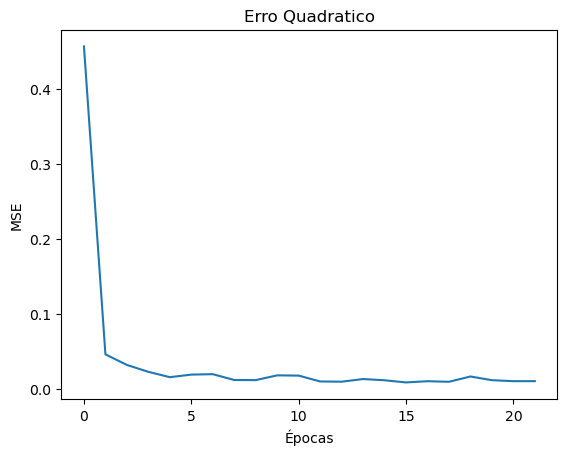

In [86]:
import matplotlib.pyplot as plt
plt.plot(mlp.loss_curve_)
plt.title('Erro Quadratico')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.show()

## Avaliação de modelos


Métricas de regressão (MSE, RMSE, R²)
Validação cruzada
Curvas de aprendizado
Matrizes de confusão.
Grid search e busca aleatória de hiperparâmetros.

In [ ]:
from sklearn.metrics import mean_squared_error

def predict_mse(model,X_test,Y_test):
    y_predic = model.predict(X_test)
    return mean_squared_error(Y_test, y_predic,multioutput='raw_values')